In [0]:
!pip install sat-search
!pip install rasterio

from satsearch import Search
from satstac import Items
from osgeo import gdal
from matplotlib import pyplot as plt
import sys
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import glob
import rasterio
import os
import shutil
import pickle

from datetime import *
from rasterio.mask import mask

     |████████████████████████████████| 19.7MB 3.4MB/s 


In [0]:
def calcularCaracteristicasBanda(directorio,fecha):
  
  in_dir = directorio+'/'+str(fecha)
  
  b4_file = glob.glob(in_dir + '/**B4.TIF') # red band
    
  dataSetB4 = gdal.Open(b4_file[0],gdal.GA_ReadOnly)
 

  if dataSetB4 is None:
    print("El archivo B4 es None")


  #cargamos la banda como conjunto de datos para poder obtener sus propiedades.
  banda = dataSetB4.GetRasterBand(1)

  #Consegumos el número de filas y columnas de la banda, que nos dará el tamaño de imagen.
  cols = dataSetB4.RasterXSize
  rows = dataSetB4.RasterYSize

  #usamos GetGeoTransform que nos da los datos de la banda.
  transform = dataSetB4.GetGeoTransform()

  xOrigin = transform[0]
  yOrigin = transform[3]
  pixelWidth = transform[1]
  pixelHeight = -transform[5] 
  


  #Leemos la banda como un array desde el punto 0,0 y ponemos de tamaño el orignial de la banda.
  #Nos servirá para poder mostar el contenido de la celda [row][col]
  
  data = banda.ReadAsArray(0, 0, cols, rows)
  
  return xOrigin, yOrigin, data, pixelWidth, pixelHeight

In [0]:
def recortarGeometria (geoms,directorio,fecha):
  in_dir = directorio+'/'+str(fecha) #ruta completa con la fecha
  
  b4_file = glob.glob(in_dir + '/**B4.TIF') # red band
  b5_file = glob.glob(in_dir + '/**B5.TIF') # Near Infrared NIR band
  

  # carga la raster band, crea una mascara con el poligno y lo extrae.
  with rasterio.open(b4_file[0]) as src:
     out_image, out_transform = mask(src, geoms, crop=True, pad=False)
  out_meta = src.meta.copy()

  # establece los meta datos de la imagen resultado.
  out_meta.update({"driver": "GTiff",
     "height": out_image.shape[1],
     "width": out_image.shape[2],
     "transform": out_transform})

  #guarda la imagen resultado.
  with rasterio.open(in_dir +"/maskedb4.tif", "w", **out_meta) as dest:
      dest.write(out_image)
  
  with rasterio.open(b5_file[0]) as src:
      out_image, out_transform = mask(src, geoms, crop=True, pad=False)
  out_meta = src.meta.copy()

  out_meta.update({"driver": "GTiff",
      "height": out_image.shape[1],
      "width": out_image.shape[2],
      "transform": out_transform})

  with rasterio.open(in_dir +"/maskedb5.tif", "w", **out_meta) as dest:
      dest.write(out_image)

In [0]:
def calcularNDVI(directorio,fecha):
  
  in_dir = directorio+'/'+str(fecha) 
  
  #Abrimos las imagenes en forma de conjunto de datos.
  dataSetMaskedB4 = gdal.Open(in_dir +'/maskedb4.tif',gdal.GA_ReadOnly)
  dataSetMaskedB5 = gdal.Open(in_dir +'/maskedb5.tif',gdal.GA_ReadOnly)

  #obtenemos la raster band de la imagen (será 1 porque solo tinee una banda) y la leemos como array numpy de float 32
  RasterBandDataSetMaskedB4 = dataSetMaskedB4.GetRasterBand(1).ReadAsArray().astype(np.float32)
  RasterBandDataSetMaskedB5 = dataSetMaskedB5.GetRasterBand(1).ReadAsArray().astype(np.float32)

  #Ndvi es igual a  (banda RED - banda NIR) / (banda RED + banda NIR)
  ndvi = (RasterBandDataSetMaskedB5 - RasterBandDataSetMaskedB4)/(RasterBandDataSetMaskedB5 + RasterBandDataSetMaskedB4)
  return ndvi

In [0]:
def comprobadorPuntosGeometriaImagen(xOrigin,yOrigin,data,pixelWidth, pixelHeight, puntos,fecha):
  print("------- Comprobando la imagen", fecha, "... -------")
  print("El origen X es:",xOrigin)
  print("El origen y es:",yOrigin)
  print("Los puntos son:",puntos)
  print("Hay en total ",len(puntos)," puntos")

  
  for point in puntos:
      col = int((point[0] - xOrigin) / pixelWidth)
      row = int((yOrigin - point[1] ) / pixelHeight)
      
      try:
         val = data[row][col]
      except:
          print("Un punto esta fuera de la imagen :",point[0],",",point[1])
          return False 
  return True

In [0]:
def mostrarYGuardarImagen(directorioDescargas,ndvi,fecha,parcela,fIniSin,fFinSin,fIniSiem,fFinSiem,fIniCre,fFinCre):
  
  # Finalmente mostramos la imagen en la pantalla
  fig = plt.figure(figsize=(5, 5))
  fig.set_facecolor('white')
  plt.imshow(ndvi,'BrBG') #Podriamos usar otros filtros de color como:  #viridis #YlGn #BrBG

  
  plt.title('NDVI ' +str(fecha))
  plt.show()
    
  try: # comprueba si exista ya el directorio, sino lo crea.
    os.stat(directorioDescargas)
  except:
    os.mkdir(directorioDescargas)

 
  direDescargaParcela = directorioDescargas+'/'+parcela
  try: # comprueba si exista ya el directorio, sino lo crea.
    os.stat(direDescargaParcela)
  except:
    os.mkdir(direDescargaParcela)
              
  
  fechaReplace = fecha.replace(year=2013) #Convertimos la fecha para que todas esten el mismo año para compararse.
  
  
  if fechaReplace >= fIniSin.date() and fechaReplace <= fFinSin.date():
      direDescargaFase = direDescargaParcela+'/'+'sinSiembra'
      print(' sinSiembra',fecha)
  elif fechaReplace >= fIniSiem.date() and fechaReplace <= fFinSiem.date():
    direDescargaFase = direDescargaParcela+'/'+'Siembra'
    print(' Siembra',fecha)
  elif fechaReplace >= fIniCre.date() and fechaReplace <= fFinCre.date():
    direDescargaFase = direDescargaParcela+'/'+'Crecimiento' 
    print(' Crecimiento',fecha)
  else:
    print('No corresponde a la temporada de este cultivo')
  
  try: # comprueba si exista ya el directorio, sino lo crea.
    os.stat(direDescargaFase)
  except:
    os.mkdir(direDescargaFase)
    
  plt.imsave(direDescargaFase+'/'+str(fecha)+'NDVIcolor'+parcela+'.png',ndvi,cmap='BrBG')
  return direDescargaParcela #devuelve la ruta donde estan todas las imagenes categorizadas



In [0]:
def leerParametrosFichero(ruta):
  diccionarioParametros = {}
  
  # Abre archivo en modo lectura
  with open(ruta,'r') as archivo:
    # inicia bucle infinito para leer línea a línea.
    while True: 
      linea = archivo.readline()  # lee línea.
      if not linea: 
          break  # Si no hay más se rompe bucle.
      linea = linea.rstrip() #Quita caracteres vacios y \n a la derecha.
      
      key, value = linea.strip().split('=') #dividimos la linea mediante el signo = . izquierda la clave y derecha valor
      key = key.strip() #quitamos espacios en blancos de la parte izquierda
      key = key.strip("'") #quitamos comillas simples de la parte izquierda
      
      value = value.strip() # #quitamos espacios en blancos de la parte derecha
      value = value.strip("'") # quitamos comillas simples de la parte derecha
      
      diccionarioParametros[key] = value
  archivo.close  # Cierra archivo
  
  return diccionarioParametros


In [0]:
def obtenerGeometriaParcela(rutaFicheroGeometria):
  poligono = []
  diccionarioPuntos = leerParametrosFichero(rutaFicheroGeometria) #obtenemos el diccionario con los puntos
  
  for punto in diccionarioPuntos.keys(): #recorremos todas las claves del diccionario
     poligono.append(eval(diccionarioPuntos[punto]))  # y las insertamos en la lista 
  
  geometria  = [{'type': 'Polygon', 'coordinates':[poligono]}] #con la lista podemos crear la geometria.
  return geometria
  

In [0]:
def procesoCalculoNDVITratamientoImagenes(parametros):
  
  print(parametros)
  #Introducimos el perdiodo de siembra del cultivo
  formatoFecha = "%d-%m-%Y"

  #Inicio del periodo donde no debe haber siembra.
  fechaInicioSinSiembra = parametros['fechaInicioSinSiembra'] 
  dateFechaInicioSinSiembra = datetime.strptime(fechaInicioSinSiembra, formatoFecha)
  #Convertimos al año 2013 por ejemplo, para que podamos comparar ya que solo nos interesan los dias y meses para las cosechas.
  dateFechaInicioSinSiembra = dateFechaInicioSinSiembra.replace(year=2013)
  
  #Fin del periodo donde no debe haber siembra.
  fechaFinSinSiembra = parametros['fechaFinSinSiembra']
  dateFechaFinSinSiembra = datetime.strptime(fechaFinSinSiembra, formatoFecha)
  dateFechaFinSinSiembra = dateFechaFinSinSiembra.replace(year=2013) 
  
  #Inicio del periodo donde comienza la siembra.
  fechaInicioSiembra = parametros['fechaInicioSiembra']
  dateFechaInicioSiembra = datetime.strptime(fechaInicioSiembra, formatoFecha)
  dateFechaInicioSiembra = dateFechaInicioSiembra.replace(year=2013)
  
  #Fin del periodo de siembra.
  fechaFinSiembra = parametros['fechaFinSiembra']
  dateFechaFinSiembra = datetime.strptime(fechaFinSiembra, formatoFecha)
  dateFechaFinSiembra = dateFechaFinSiembra.replace(year=2013)
  
  #Inicio del periodo donde comienza el crecimiento.
  fechaInicioCrecimiento = parametros['fechaInicioCrecimiento']
  dateFechaInicioCrecimiento = datetime.strptime(fechaInicioCrecimiento, formatoFecha)
  dateFechaInicioCrecimiento = dateFechaInicioCrecimiento.replace(year=2013)
  
  #Fin del periodo de crecimiento
  fechaFinCrecimiento = parametros['fechaFinCrecimiento']
  dateFechaFinCrecimiento = datetime.strptime(fechaFinCrecimiento, formatoFecha)
  dateFechaFinCrecimiento = dateFechaFinCrecimiento.replace(year=2013)
  
  
  #Indicamos la ruta donde estan las imagenes descargadas
  rutaImagenesDescargadas = parametros['rutaImagenesDescargadas']
  
  #Indicamos la ruta donde esta el fichero binario con las fechas de las imagenes descargadas
  rutaFechasImagenesDescargadas = parametros['rutaFechasImagenesDescargadas']
  
  #Obtenemos la lista de fechas disponibles en la ruta de imagenes descargadas
  with open(rutaFechasImagenesDescargadas, 'rb') as ficheroFechas:
    listaFechasDescargadas = pickle.load(ficheroFechas)
  ficheroFechas.close
  
  #Obtenemos la geometria de la parcela
  rutaFicheroGeometria = parametros['rutaFicheroGeometria']
  geometria = obtenerGeometriaParcela(rutaFicheroGeometria) 

  
  #Obtenemos el nombre asignado a la parcela
  nombreParcela = parametros['nombreParcela']
  
  #Indicamos el nombre del directorio donde queremos que se guarden las imageness tratadas
  rutaGuardarImagenesTratadas = parametros['rutaGuardarImagenesTratadas']
  
  #Esta fecha se indica porque el fichero imagen esta corrupto. (en otras zonas quizas no sea necesaria)
  fechaProblematica = date(2018, 12, 29)
  
   
  #Recorremos todas las fechas que tenemos descargadas anteriormente
  for fecha in listaFechasDescargadas:
    if fecha == fechaProblematica :
        print("------- La imagen",fecha, "no es valida para procesarla ARCHIVO DAÑADO ------")
    else:
      dateFecha = fecha.replace(year=2013) 
      if dateFecha >= dateFechaInicioSinSiembra.date() and dateFecha < dateFechaFinCrecimiento.date():
        oriX,oriY,data, pixelWidth, pixelHeight = calcularCaracteristicasBanda(rutaImagenesDescargadas,fecha)
        valida = comprobadorPuntosGeometriaImagen(oriX,oriY,data,pixelWidth, pixelHeight,geometria[0]['coordinates'][0],fecha)
    
        if valida:
          print("------- La imagen" ,fecha, "es valida para procesarla -------")
          print("------- Procesando la imagen" ,fecha, " ... -------")
          recortarGeometria(geometria,rutaImagenesDescargadas,fecha)
          NDVI = calcularNDVI(rutaImagenesDescargadas,fecha)
          rutaImagenesProcesada = mostrarYGuardarImagen(rutaGuardarImagenesTratadas,NDVI,fecha,nombreParcela,dateFechaInicioSinSiembra,
                                                        dateFechaFinSinSiembra,dateFechaInicioSiembra,dateFechaFinSiembra,
                                                        dateFechaInicioCrecimiento,dateFechaFinCrecimiento)
          
        else:
          print("------- La imagen",fecha, "no es valida para procesarla ------")
       
      else:
        print("------- La fecha",fecha, "no es valida para este cultivo. ------")

  
  
  print("------- Comprimiendo las imágenes resultado... --------")  
  
  
  output_filename = 'ImagenesProcesadas' + nombreParcela
  shutil.make_archive(output_filename, 'zip', rutaImagenesProcesada) #Comprimimos la carpeta resultante con las imagenes.

    
  print("------- Fin del proceso de Calculo de NDVI y Tratamiento de Imágenes --------")  
 
  

{'fechaInicioSinSiembra': '01-03-2010', 'fechaFinSinSiembra': '11-05-2010', 'fechaInicioSiembra': '12-05-2010', 'fechaFinSiembra': '16-06-2010', 'fechaInicioCrecimiento': '17-06-2010', 'fechaFinCrecimiento': '02-10-2010', 'rutaImagenesDescargadas': '/content/descargas/ImagenesSatelite', 'rutaFechasImagenesDescargadas': '/content/FechasDescargadasSatelite.txt', 'rutaFicheroGeometria': '/content/geometria.txt', 'nombreParcela': 'ParcelaPrueba', 'rutaGuardarImagenesTratadas': '/content/ImagenesTratadas'}
------- Comprobando la imagen 2014-03-05 ... -------
El origen X es: 181185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-03-05 es valida para procesarla -------
------- Procesando la imagen 2014-03-05  ... -------


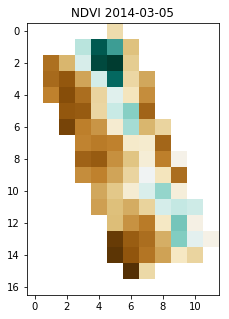

 sinSiembra 2014-03-05
------- Comprobando la imagen 2014-04-06 ... -------
El origen X es: 179685.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-04-06 es valida para procesarla -------
------- Procesando la imagen 2014-04-06  ... -------


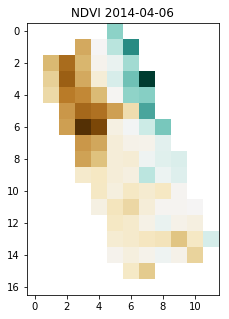

 sinSiembra 2014-04-06
------- Comprobando la imagen 2014-06-09 ... -------
El origen X es: 182685.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-06-09 es valida para procesarla -------
------- Procesando la imagen 2014-06-09  ... -------


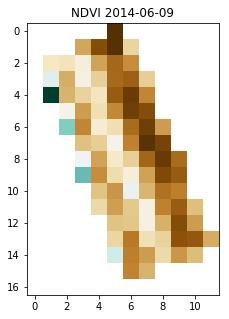

 Siembra 2014-06-09
------- Comprobando la imagen 2014-06-25 ... -------
El origen X es: 184485.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-06-25 es valida para procesarla -------
------- Procesando la imagen 2014-06-25  ... -------


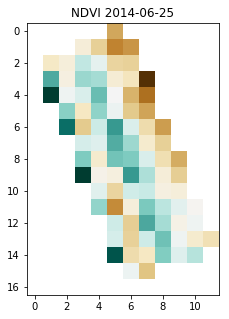

 Crecimiento 2014-06-25
------- Comprobando la imagen 2014-07-11 ... -------
El origen X es: 183285.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-07-11 es valida para procesarla -------
------- Procesando la imagen 2014-07-11  ... -------


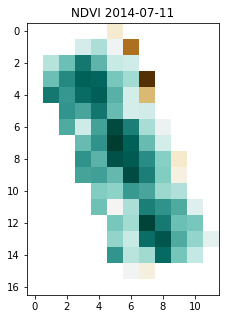

 Crecimiento 2014-07-11
------- Comprobando la imagen 2014-07-27 ... -------
El origen X es: 184185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-07-27 es valida para procesarla -------
------- Procesando la imagen 2014-07-27  ... -------


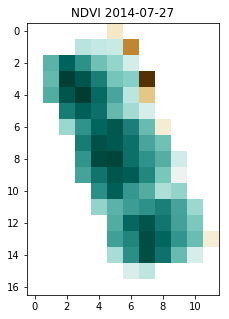

 Crecimiento 2014-07-27
------- Comprobando la imagen 2014-08-12 ... -------
El origen X es: 182685.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-08-12 es valida para procesarla -------
------- Procesando la imagen 2014-08-12  ... -------


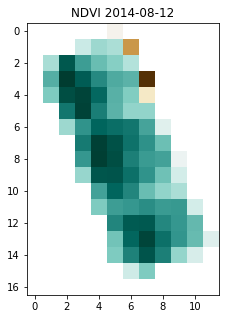

 Crecimiento 2014-08-12
------- Comprobando la imagen 2014-08-28 ... -------
El origen X es: 183585.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-08-28 es valida para procesarla -------
------- Procesando la imagen 2014-08-28  ... -------


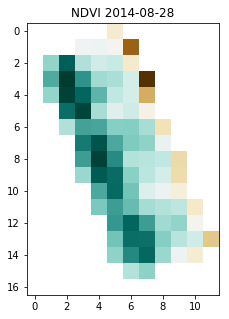

 Crecimiento 2014-08-28
------- Comprobando la imagen 2014-09-13 ... -------
El origen X es: 182985.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2014-09-13 es valida para procesarla -------
------- Procesando la imagen 2014-09-13  ... -------


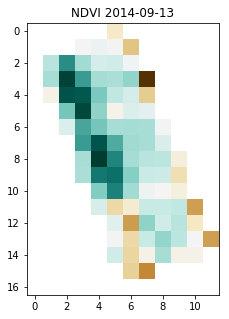

 Crecimiento 2014-09-13
------- La fecha 2014-10-31 no es valida para este cultivo. ------
------- La fecha 2015-01-03 no es valida para este cultivo. ------
------- La fecha 2015-01-19 no es valida para este cultivo. ------
------- Comprobando la imagen 2015-03-08 ... -------
El origen X es: 180885.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2015-03-08 es valida para procesarla -------
------- Procesando la imagen 2015-03-08  ... -------


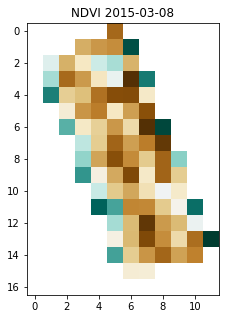

 sinSiembra 2015-03-08
------- Comprobando la imagen 2015-05-11 ... -------
El origen X es: 179085.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2015-05-11 es valida para procesarla -------
------- Procesando la imagen 2015-05-11  ... -------


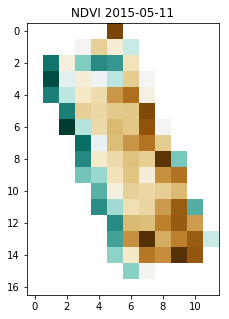

 sinSiembra 2015-05-11
------- Comprobando la imagen 2015-05-27 ... -------
El origen X es: 183885.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2015-05-27 es valida para procesarla -------
------- Procesando la imagen 2015-05-27  ... -------


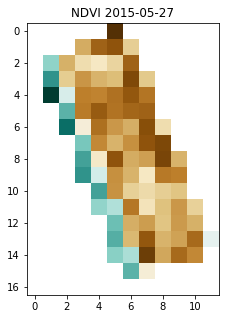

 Siembra 2015-05-27
------- Comprobando la imagen 2015-06-28 ... -------
El origen X es: 183885.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2015-06-28 es valida para procesarla -------
------- Procesando la imagen 2015-06-28  ... -------


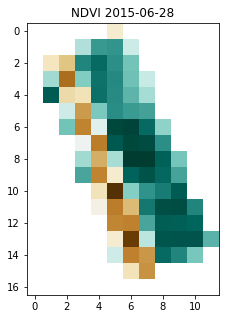

 Crecimiento 2015-06-28
------- Comprobando la imagen 2015-07-14 ... -------
El origen X es: 182685.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2015-07-14 es valida para procesarla -------
------- Procesando la imagen 2015-07-14  ... -------


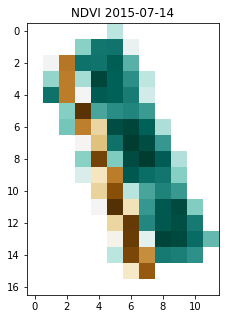

 Crecimiento 2015-07-14
------- Comprobando la imagen 2015-07-30 ... -------
El origen X es: 183885.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2015-07-30 es valida para procesarla -------
------- Procesando la imagen 2015-07-30  ... -------


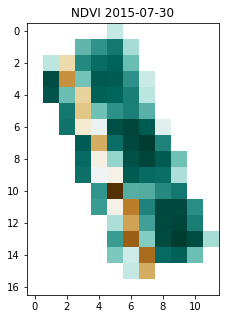

 Crecimiento 2015-07-30
------- Comprobando la imagen 2015-08-15 ... -------
El origen X es: 184185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2015-08-15 es valida para procesarla -------
------- Procesando la imagen 2015-08-15  ... -------


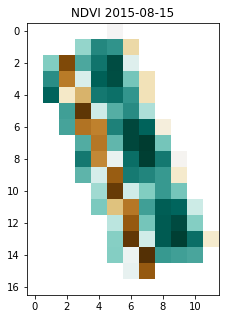

 Crecimiento 2015-08-15
------- La fecha 2015-10-02 no es valida para este cultivo. ------
------- La fecha 2015-12-05 no es valida para este cultivo. ------
------- Comprobando la imagen 2016-06-30 ... -------
El origen X es: 183585.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2016-06-30 es valida para procesarla -------
------- Procesando la imagen 2016-06-30  ... -------


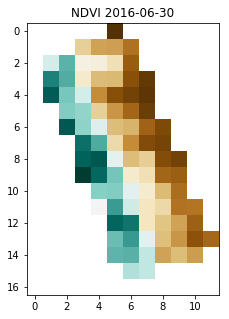

 Crecimiento 2016-06-30
------- Comprobando la imagen 2016-07-16 ... -------
El origen X es: 183285.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2016-07-16 es valida para procesarla -------
------- Procesando la imagen 2016-07-16  ... -------


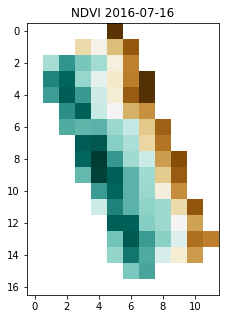

 Crecimiento 2016-07-16
------- Comprobando la imagen 2016-08-01 ... -------
El origen X es: 183885.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2016-08-01 es valida para procesarla -------
------- Procesando la imagen 2016-08-01  ... -------


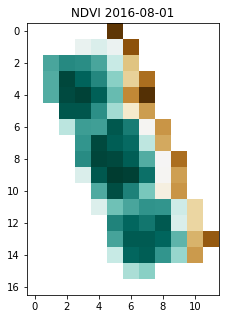

 Crecimiento 2016-08-01
------- Comprobando la imagen 2016-09-02 ... -------
El origen X es: 183285.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2016-09-02 es valida para procesarla -------
------- Procesando la imagen 2016-09-02  ... -------


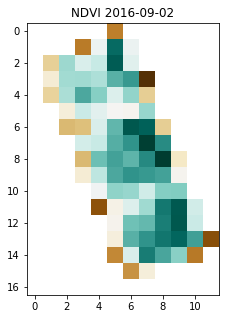

 Crecimiento 2016-09-02
------- Comprobando la imagen 2016-09-18 ... -------
El origen X es: 183285.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2016-09-18 es valida para procesarla -------
------- Procesando la imagen 2016-09-18  ... -------


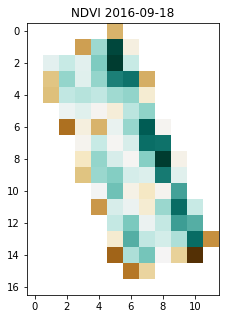

 Crecimiento 2016-09-18
------- La fecha 2016-10-04 no es valida para este cultivo. ------
------- La fecha 2016-12-23 no es valida para este cultivo. ------
------- La fecha 2017-01-08 no es valida para este cultivo. ------
------- La fecha 2017-01-24 no es valida para este cultivo. ------
------- La fecha 2017-02-25 no es valida para este cultivo. ------
------- Comprobando la imagen 2017-03-29 ... -------
El origen X es: 181485.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-03-29 es valida para procesarla -------
------- Procesando la imagen 2017-03-29  ... -------


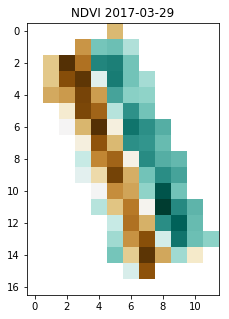

 sinSiembra 2017-03-29
------- Comprobando la imagen 2017-04-14 ... -------
El origen X es: 180585.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-04-14 es valida para procesarla -------
------- Procesando la imagen 2017-04-14  ... -------


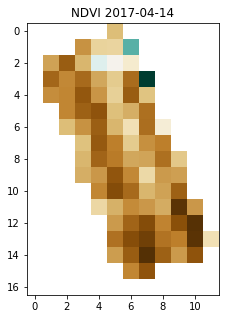

 sinSiembra 2017-04-14
------- Comprobando la imagen 2017-05-16 ... -------
El origen X es: 183885.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-05-16 es valida para procesarla -------
------- Procesando la imagen 2017-05-16  ... -------


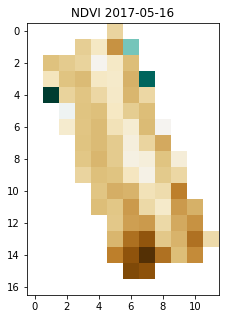

 Siembra 2017-05-16
------- Comprobando la imagen 2017-06-01 ... -------
El origen X es: 182985.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-06-01 es valida para procesarla -------
------- Procesando la imagen 2017-06-01  ... -------


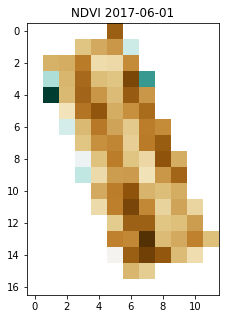

 Siembra 2017-06-01
------- Comprobando la imagen 2017-06-17 ... -------
El origen X es: 182985.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-06-17 es valida para procesarla -------
------- Procesando la imagen 2017-06-17  ... -------


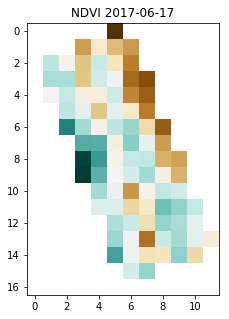

 Crecimiento 2017-06-17
------- Comprobando la imagen 2017-07-03 ... -------
El origen X es: 183885.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-07-03 es valida para procesarla -------
------- Procesando la imagen 2017-07-03  ... -------


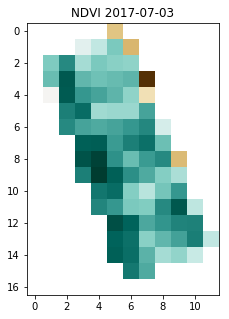

 Crecimiento 2017-07-03
------- Comprobando la imagen 2017-07-19 ... -------
El origen X es: 184185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-07-19 es valida para procesarla -------
------- Procesando la imagen 2017-07-19  ... -------


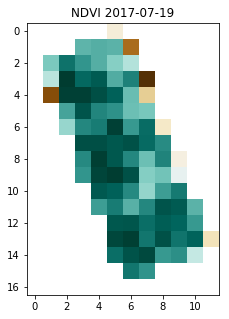

 Crecimiento 2017-07-19
------- Comprobando la imagen 2017-08-04 ... -------
El origen X es: 183285.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-08-04 es valida para procesarla -------
------- Procesando la imagen 2017-08-04  ... -------


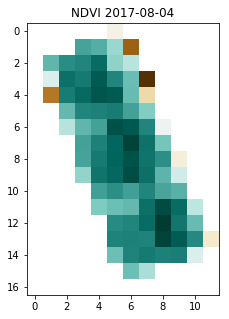

 Crecimiento 2017-08-04
------- Comprobando la imagen 2017-08-20 ... -------
El origen X es: 182985.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-08-20 es valida para procesarla -------
------- Procesando la imagen 2017-08-20  ... -------


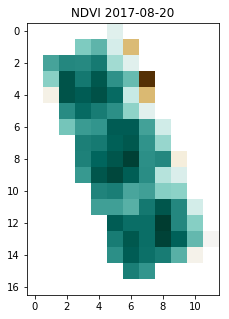

 Crecimiento 2017-08-20
------- Comprobando la imagen 2017-09-05 ... -------
El origen X es: 183585.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2017-09-05 es valida para procesarla -------
------- Procesando la imagen 2017-09-05  ... -------


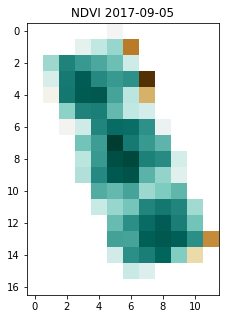

 Crecimiento 2017-09-05
------- La fecha 2017-10-07 no es valida para este cultivo. ------
------- La fecha 2017-10-23 no es valida para este cultivo. ------
------- La fecha 2017-11-08 no es valida para este cultivo. ------
------- La fecha 2018-02-12 no es valida para este cultivo. ------
------- Comprobando la imagen 2018-04-17 ... -------
El origen X es: 181185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2018-04-17 es valida para procesarla -------
------- Procesando la imagen 2018-04-17  ... -------


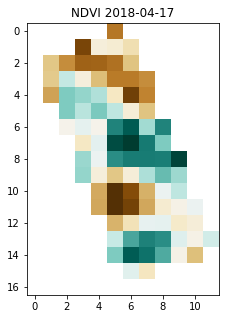

 sinSiembra 2018-04-17
------- Comprobando la imagen 2018-06-20 ... -------
El origen X es: 184185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2018-06-20 es valida para procesarla -------
------- Procesando la imagen 2018-06-20  ... -------


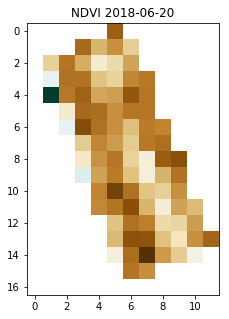

 Crecimiento 2018-06-20
------- Comprobando la imagen 2018-07-06 ... -------
El origen X es: 184185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2018-07-06 es valida para procesarla -------
------- Procesando la imagen 2018-07-06  ... -------


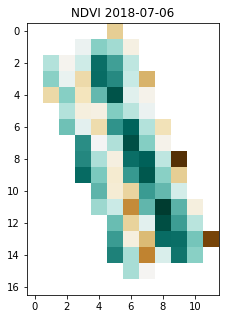

 Crecimiento 2018-07-06
------- Comprobando la imagen 2018-07-22 ... -------
El origen X es: 184785.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2018-07-22 es valida para procesarla -------
------- Procesando la imagen 2018-07-22  ... -------


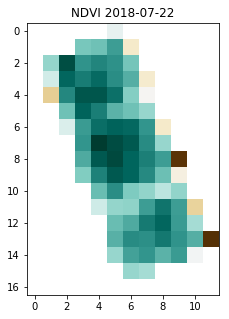

 Crecimiento 2018-07-22
------- Comprobando la imagen 2018-08-07 ... -------
El origen X es: 184485.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2018-08-07 es valida para procesarla -------
------- Procesando la imagen 2018-08-07  ... -------


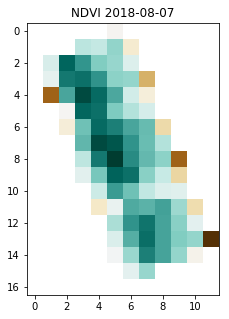

 Crecimiento 2018-08-07
------- Comprobando la imagen 2018-08-23 ... -------
El origen X es: 184185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2018-08-23 es valida para procesarla -------
------- Procesando la imagen 2018-08-23  ... -------


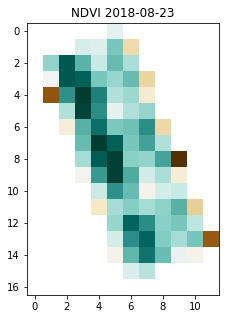

 Crecimiento 2018-08-23
------- Comprobando la imagen 2018-09-24 ... -------
El origen X es: 184185.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2018-09-24 es valida para procesarla -------
------- Procesando la imagen 2018-09-24  ... -------


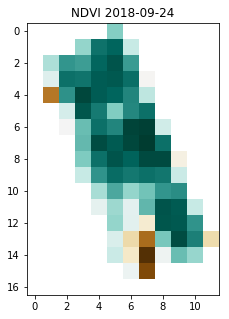

 Crecimiento 2018-09-24
------- La imagen 2018-12-29 no es valida para procesarla ARCHIVO DAÑADO ------
------- La fecha 2019-01-14 no es valida para este cultivo. ------
------- La fecha 2019-02-15 no es valida para este cultivo. ------
------- Comprobando la imagen 2019-03-03 ... -------
El origen X es: 183285.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2019-03-03 es valida para procesarla -------
------- Procesando la imagen 2019-03-03  ... -------


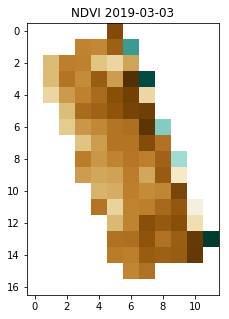

 sinSiembra 2019-03-03
------- Comprobando la imagen 2019-03-19 ... -------
El origen X es: 182985.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2019-03-19 es valida para procesarla -------
------- Procesando la imagen 2019-03-19  ... -------


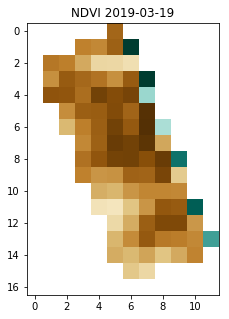

 sinSiembra 2019-03-19
------- Comprobando la imagen 2019-05-22 ... -------
El origen X es: 182385.0
El origen y es: 4586715.0
Los puntos son: [(269032.41, 4430443.21), (269201.66, 4430026.16), (269023.63, 4429954.26), (268865.4, 4430374.6), (269032.41, 4430443.21)]
Hay en total  5  puntos
------- La imagen 2019-05-22 es valida para procesarla -------
------- Procesando la imagen 2019-05-22  ... -------


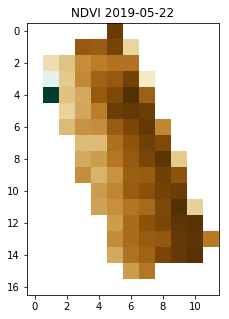

 Siembra 2019-05-22
------- Comprimiendo las imágenes resultado... --------
------- Fin del proceso de Calculo de NDVI y Tratamiento de Imágenes --------


In [0]:
param = leerParametrosFichero('/content/parametrosCalculoNDVITratamiento.txt')
procesoCalculoNDVITratamientoImagenes(param)